# Лабораторные работы по Системам искусственного интеллекта

**Тема**: рекомендация аниме фильмов и сериалов.

**Датасет**: `MyAnimeList` - данные за 1942-2019 года.

**Выделенные признаки**:
- Набор жанров (категориальная переменная)
- Дата выхода в эфир (численная переменная)
- Количество эпизодов (численная переменная)
- Длительность одной серии (численная переменная)
- Тип (категориальная переменная - одно из `TV`, `Movie`, `OVA`, `ONA`)
    - `OVA` (Original Video Animation) - аниме, которое было выпущено в продажу на тех или иных видеоносителях (видеокассеты, DVD) и предварительно никогда не транслировалось ни на телеканалах, ни в кинотеатрах.
    - `ONA` (original net animation) - аниме, выходящее в сети интернет и, как правило, не доходящее до продажи на видео или показа на ТВ или в кинотеатрах. Очень часто ONA представляет собой низкобюджетные "самодельные" аниме-короткометражки, созданные начинающими аниме-режиссерами и бесплатно распространяемые в сети.

---

**Дерево жанров**:

![дерево жанров](./genres.png)

---

В качестве лингвистической переменной предложено выбрать длительность одной серии со следующими категориями:

- Очень короткая (серия)
- Короткая
- Недолгая
- Не очень долгая
- Не очень короткая
- Некороткая
- Долгая
- Очень долгая

---

## Рассчитаны следующие простые меры схожести:

1. По жанрам. В основе метрики - рассчет расстояний между жанрами в дереве и подсчет коэффициента Жаккара.

2. По дате выхода в эфир. Даты переводятся в численное представление и вычисляется мера схожести: $sim_2(a_1, a_2) = exp\left(\frac{-|a_{1t} - a_{2t}|}{K}\right)$,\
где $K$ - нормировочный коэффициент эмпирически подобранный как 900 дней.

3. По количеству эпизодов. Формула: $sim_3(ep_1, ep_2) = exp\left(-\frac{|ep_1 - ep_2|}{10}\right)$.

## Расчет комбинированной меры схожести:

Комбинированная мера схожести рассчитывается по формуле:

$$sim(a_1, a_2) = \frac{w_1 sim_1(a_1, a_2) + w_2 sim_2(a_1, a_2) + w_3 sim_3(a_1, a_2)}{w_1 + w_2 + w_3},$$

где $w_1 = 0.9$, $w_2 = 0.5$, $w_3 = 0.2$ - подобранные эмпирически весовые параметры формулы.

In [30]:
import pandas as pd

anime = pd.read_csv('anime_cleaned_old.csv')
anime = anime.loc[anime['genre'].notnull()]
anime.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [3]:
# extract and filter genres
genres = set()

for genres_lst in anime['genre'].values:
    for g in genres_lst.split(', '):
        genres.add(g)

genres = [
    'Psychological',
    'Action',
    'Shounen',
    'Supernatural',
    # 'Dementia',
    'Sports',
    'Martial Arts',
    'Historical',
    'Demons',
    'Josei',
    'Space',
    # 'Harem',
    # 'Kids',
    # 'Ecchi',
    'Mystery',
    'Vampire',
    # 'Shounen Ai',
    # 'Yuri',
    'Cars',
    'Super Power',
    'Seinen',
    'Sci-Fi',
    'Magic',
    'Parody',
    'Thriller',
    'Music',
    'Game',
    'Fantasy',
    'Adventure',
    'Romance',
    'Police',
    'Drama',
    # 'Hentai',
    'Samurai',
    'School',
    'Comedy',
    'Shoujo',
    # 'Yaoi',
    'Military',
    'Horror',
    'Slice of Life',
    # 'Shoujo Ai',
    # 'Shounen Ai',
    'Mecha'
]

filtered_genres = ['Dementia', 'Harem', 'Kids', 'Ecchi', 'Shounen Ai', 'Yuri', 'Hentai', 'Yaoi', 'Shoujo Ai', 'Shounen Ai']
def genre_filter(genre_lst: str) -> bool:
    for g in genre_lst.split(', '):
        if g in filtered_genres:
            return False
    return True

anime = anime.loc[anime['genre'].apply(genre_filter)]

In [4]:
# select well-known titles

titles = (
    'Bleach',
    'Naruto',
    'Black Blood Brothers',

    'Kuroko no Basket',
    'Area no Kishi',
    'Teekyuu',

    'Arc the Lad',
    'Vampire Hunter D (2000)',
    'JoJo no Kimyou na Bouken: Adventure',

    'Violet Evergarden',
    'Yuuki Yuuna wa Yuusha de Aru: Yuusha no Shou',
    'Kemono no Souja Erin',

    'Made in Abyss',
    'Steins;Gate',
    'Wolf&#039;s Rain',
    
    'Gintama',
    'Great Teacher Onizuka',
    'Hellsing Ultimate',
)

featured = anime[anime['title'].isin(titles)]
featured = featured.loc[featured['title'].apply(lambda s: titles.index(s)).sort_values().index]
featured

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
14,269,Bleach,Bleach,BLEACH - ブリーチ -,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,366,Finished Airing,...,Tuesdays at 18:00 (JST),"{'Adaptation': [{'mal_id': 12, 'type': 'manga'...","TV Tokyo, Aniplex, Dentsu, TV Tokyo Music, Stu...",Viz Media,Studio Pierrot,"Action, Adventure, Comedy, Super Power, Supern...","['#01: ""*~Asterisk~ (*～アスタリスク～)"" by Orange Ran...","['#01: ""Life is Like a Boat"" by Rie Fu (eps 1-...",24.0,2004.0
2199,20,Naruto,Naruto,ナルト,NARUTO,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,220,Finished Airing,...,Thursdays at 19:30 (JST),"{'Adaptation': [{'mal_id': 11, 'type': 'manga'...","TV Tokyo, Aniplex, Shueisha",Viz Media,Studio Pierrot,"Action, Adventure, Comedy, Super Power, Martia...","['#01: ""R★O★C★K★S"", by Hound Dog (eps 1-25)', ...","['#01: ""Wind"" by Akeboshi (eps 1-25)', '#02: ""...",23.0,2002.0
3391,1498,Black Blood Brothers,Black Blood Brothers,ブラック・ブラッド・ブラザーズ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,12,Finished Airing,...,Fridays at 23:30 (JST),"{'Adaptation': [{'mal_id': 4174, 'type': 'mang...","Toshiba Entertainment, Happinet Pictures",Funimation,Group TAC,"Action, Comedy, Fantasy, Shounen, Supernatural...","['""Ashita no Kioku"" by Naozumi Takahashi']","['""Shinkirou"" by LOVEHOLIC']",25.0,2006.0
1792,11771,Kuroko no Basket,Kuroko&#039;s Basketball,黒子のバスケ,"Kuroko no Basuke, KuroBas",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Sundays at 01:58 (JST),"{'Adaptation': [{'mal_id': 11652, 'type': 'man...","Bandai Visual, Lantis, Nihon Ad Systems, Maini...",NaN,Production I.G,"Comedy, School, Shounen, Sports","['#1: ""Can Do"" by GRANRODEO (eps 1-13)', '#2: ...","['#1: ""Start it right away"" by Hyadain (eps 1-...",24.0,2012.0
5923,11697,Area no Kishi,The Knight in the Area,エリアの騎士,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,37,Finished Airing,...,Saturdays at 06:00 (JST),"{'Adaptation': [{'mal_id': 8795, 'type': 'mang...",TV Asahi,NaN,Shin-Ei Animation,"Comedy, School, Shounen, Sports","['""Higher Ground (ハイヤーグラウンド)"" by S.R.S']",[],25.0,2012.0
170,15125,Teekyuu,Teekyu,てーきゅう,"Tekyuu, Te-kyu",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Sundays at 22:27 (JST),"{'Adaptation': [{'mal_id': 44949, 'type': 'man...","DAX Production, Earth Star Entertainment",NaN,MAPPA,"Comedy, School, Shounen, Sports","['#1: ""Botsuraku Kizoku no Tame no Teekyu (没落貴...",[],2.0,2012.0
1732,55,Arc the Lad,NaN,アークザラッド,Arc,https://myanimelist.cdn-dena.com/images/anime/...,TV,Game,26,Finished Airing,...,Mondays at 19:00 (JST),[],"Sony Pictures Entertainment, Aniplex",ADV Films,Bee Train,"Action, Adventure, Fantasy, Horror, Sci-Fi","['""Arc the Lad ~Main Theme~"" by Masahiro Andou']","['#1: ""Happy Tomorrow"" by NiNa (eps 01-12)', '...",22.0,1999.0
2358,543,Vampire Hunter D (2000),Vampire Hunter D: Bloodlust,バンパイアハンターD,"Vampire Hunter D (2001), Vampire Hunter D Movie",https://myanimelist.cdn-dena.com/images/anime/...,Movie,Novel,1,Finished Airing,...,NaN,"{'Adaptation': [{'mal_id': 1360, 'type': 'mang...","Animate Film, Movic","Discotek Media, Urban Vision",Madhouse,"Action, Drama, Fantasy, Horror, Romance, Sci-F...",[],"['""Tooku Made"" by Do As Infinity']",97.0,2000.0
1517,665,JoJo no Kimyou na Bouken: Adventure,JoJo&#039;s Bizarre Adventure,ジョジョの奇妙な冒険 ADVENTURE,JoJo&#039;s Bizarre Adventure (2000),https://myanimelist.cdn-dena.com/images/anime/...,OVA,Manga,7,Finished Airing,...,NaN,"{'Adaptation': [{'mal_id': 872, 'type': 'manga...",Shueisha,Super Techno Arts,APPP,"Adventure, Drama, Fantasy, Horror, Shounen, Su...",[],[],30.0,2000.0
3296,33352,Violet Evergarden,Violet Evergarden,ヴァイオレット・エヴァーガーデン,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,13,Fin

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def matrix_builder(frame: pd.DataFrame, metric):
    n = len(frame)
    XY = np.zeros((n, n))
    for row in range(n):
        for col in range(n):
            row1 = frame.iloc[row]
            row2 = frame.iloc[col]
            XY[row, col] = metric(row1, row2)
    return XY

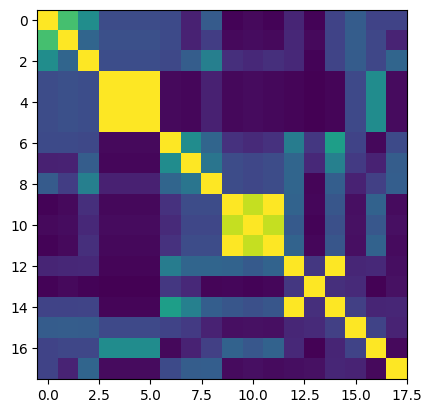

In [56]:
import datetime
import treegenerator

# compare by genres
__genr_tree = treegenerator.load_best_genres_tree()
def simple_metric1(row1: pd.DataFrame, row2: pd.DataFrame):
    genres1 = row1['genre'].split(', ')
    genres2 = row2['genre'].split(', ')
    return treegenerator.compute_similarity(__genr_tree, genres1, genres2)

genres_mat = matrix_builder(featured, simple_metric1)
plt.imshow(genres_mat, interpolation='nearest')
plt.show()

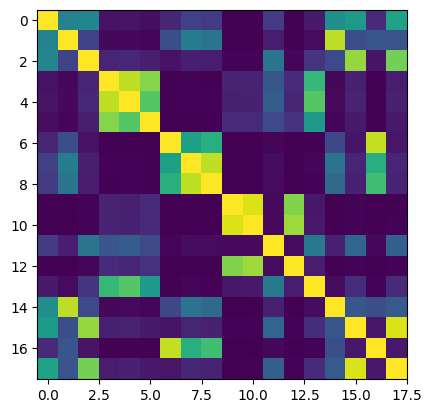

In [7]:
# compare by aired dates
def simple_metric2(row1: pd.DataFrame, row2: pd.DataFrame):
    def parse_datetime(st: str):
        if st != '?':
            return datetime.datetime.strptime(st, "%b %d, %Y")
        return datetime.datetime.now()
    aired1 = list(map(parse_datetime, row1['aired_string'].split(' to ')))
    aired2 = list(map(parse_datetime, row2['aired_string'].split(' to ')))
    t = abs(aired1[0] - aired2[0]).days
    return np.exp(-t / 900)

aired_mat = matrix_builder(featured, simple_metric2)
plt.imshow(aired_mat, interpolation='nearest')
plt.show()

In [58]:
# compare by type
def simple_metric_type(row1: pd.DataFrame, row2: pd.DataFrame):
    type1 = row1['type']
    type2 = row2['type']
    return 1 if type1 == type2 else 0

# aired_mat = matrix_builder(featured, simple_metric_type)
# plt.imshow(aired_mat, interpolation='nearest')
# plt.show()

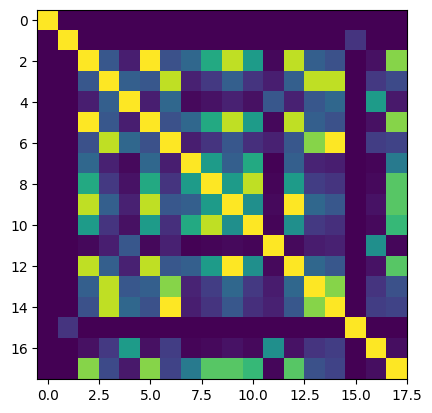

In [21]:
# compare by duration
def simple_metric3(row1: pd.DataFrame, row2: pd.DataFrame):
    dur1 = int(row1['episodes']) if row1['episodes'] != 0 else 1
    dur2 = int(row2['episodes']) if row2['episodes'] != 0 else 1
    t = abs(dur1 - dur2)
    return np.exp(-t / 10)

studio_mat = matrix_builder(featured, simple_metric3)
plt.imshow(studio_mat, interpolation='nearest')
plt.show()

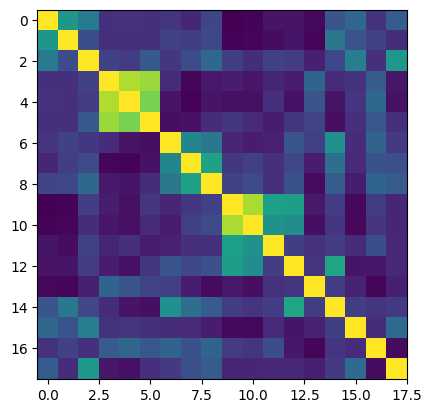

In [31]:
# combined metric
def combined_metric(row1: pd.DataFrame, row2: pd.DataFrame, w1, w2, w3):
    m1 = simple_metric1(row1, row2)
    m2 = simple_metric2(row1, row2)
    m3 = simple_metric3(row1, row2)
    return (w1 * m1 + w2 * m2 + w3 * m3) / (w1 + w2 + w3)

def mse_learner() -> (float, float, float):
    w1, w2, w3 = 0.0918, 1.621, 0.17
    expect_output = np.array([
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
    ], dtype=np.float64)
    expect_output = expect_output.reshape((18, 18))
    mat = matrix_builder(featured, lambda row1, row2: combined_metric(row1, row2, w1, w2, w3))
    mse = np.square(mat - expect_output).sum()
    
    def dmse(dw1, dw2, dw3):
        mat1 = matrix_builder(featured, lambda row1, row2: combined_metric(row1, row2, w1, w2, w3))
        mat2 = matrix_builder(featured, lambda row1, row2: combined_metric(row1, row2, w1 + dw1, w2 + dw2, w3 + dw3))
        mse1 = np.square(mat1 - expect_output).sum()
        mse2 = np.square(mat2 - expect_output).sum()
        return mse2 - mse1
        
    dw1, dw2, dw3 = 1e-2, 1e-2, 1e-2
    for i in range(100):
        dmse1 = dmse(dw1, 0, 0)
        dmse2 = dmse(0, dw2, 0)
        dmse3 = dmse(0, 0, dw3)
        w1 -= 3 * dmse1 * dw1
        w2 -= 3 * dmse2 * dw2
        w3 -= 3 * dmse3 * dw3
        
        mat = matrix_builder(featured, lambda row1, row2: combined_metric(row1, row2, w1, w2, w3))
        mse = np.square(mat - expect_output).sum()
        print('mse:', mse, 'weights:', w1, w2, w3)
    
    return w1, w2, w3

# w1, w2, w3 = mse_learner()
w1, w2, w3 = 0.9, 0.5, 0.2

combined_mat = matrix_builder(featured, lambda row1, row2: combined_metric(row1, row2, w1, w2, w3))
plt.imshow(combined_mat, interpolation='nearest')
plt.show()

In [60]:
featured

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
14,269,Bleach,Bleach,BLEACH - ブリーチ -,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,366,Finished Airing,...,Tuesdays at 18:00 (JST),"{'Adaptation': [{'mal_id': 12, 'type': 'manga'...","TV Tokyo, Aniplex, Dentsu, TV Tokyo Music, Stu...",Viz Media,Studio Pierrot,"Action, Adventure, Comedy, Super Power, Supern...","['#01: ""*~Asterisk~ (*～アスタリスク～)"" by Orange Ran...","['#01: ""Life is Like a Boat"" by Rie Fu (eps 1-...",24.0,2004.0
2199,20,Naruto,Naruto,ナルト,NARUTO,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,220,Finished Airing,...,Thursdays at 19:30 (JST),"{'Adaptation': [{'mal_id': 11, 'type': 'manga'...","TV Tokyo, Aniplex, Shueisha",Viz Media,Studio Pierrot,"Action, Adventure, Comedy, Super Power, Martia...","['#01: ""R★O★C★K★S"", by Hound Dog (eps 1-25)', ...","['#01: ""Wind"" by Akeboshi (eps 1-25)', '#02: ""...",23.0,2002.0
3391,1498,Black Blood Brothers,Black Blood Brothers,ブラック・ブラッド・ブラザーズ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,12,Finished Airing,...,Fridays at 23:30 (JST),"{'Adaptation': [{'mal_id': 4174, 'type': 'mang...","Toshiba Entertainment, Happinet Pictures",Funimation,Group TAC,"Action, Comedy, Fantasy, Shounen, Supernatural...","['""Ashita no Kioku"" by Naozumi Takahashi']","['""Shinkirou"" by LOVEHOLIC']",25.0,2006.0
1792,11771,Kuroko no Basket,Kuroko&#039;s Basketball,黒子のバスケ,"Kuroko no Basuke, KuroBas",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Sundays at 01:58 (JST),"{'Adaptation': [{'mal_id': 11652, 'type': 'man...","Bandai Visual, Lantis, Nihon Ad Systems, Maini...",NaN,Production I.G,"Comedy, School, Shounen, Sports","['#1: ""Can Do"" by GRANRODEO (eps 1-13)', '#2: ...","['#1: ""Start it right away"" by Hyadain (eps 1-...",24.0,2012.0
5923,11697,Area no Kishi,The Knight in the Area,エリアの騎士,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,37,Finished Airing,...,Saturdays at 06:00 (JST),"{'Adaptation': [{'mal_id': 8795, 'type': 'mang...",TV Asahi,NaN,Shin-Ei Animation,"Comedy, School, Shounen, Sports","['""Higher Ground (ハイヤーグラウンド)"" by S.R.S']",[],25.0,2012.0
170,15125,Teekyuu,Teekyu,てーきゅう,"Tekyuu, Te-kyu",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Sundays at 22:27 (JST),"{'Adaptation': [{'mal_id': 44949, 'type': 'man...","DAX Production, Earth Star Entertainment",NaN,MAPPA,"Comedy, School, Shounen, Sports","['#1: ""Botsuraku Kizoku no Tame no Teekyu (没落貴...",[],2.0,2012.0
1732,55,Arc the Lad,NaN,アークザラッド,Arc,https://myanimelist.cdn-dena.com/images/anime/...,TV,Game,26,Finished Airing,...,Mondays at 19:00 (JST),[],"Sony Pictures Entertainment, Aniplex",ADV Films,Bee Train,"Action, Adventure, Fantasy, Horror, Sci-Fi","['""Arc the Lad ~Main Theme~"" by Masahiro Andou']","['#1: ""Happy Tomorrow"" by NiNa (eps 01-12)', '...",22.0,1999.0
2358,543,Vampire Hunter D (2000),Vampire Hunter D: Bloodlust,バンパイアハンターD,"Vampire Hunter D (2001), Vampire Hunter D Movie",https://myanimelist.cdn-dena.com/images/anime/...,Movie,Novel,1,Finished Airing,...,NaN,"{'Adaptation': [{'mal_id': 1360, 'type': 'mang...","Animate Film, Movic","Discotek Media, Urban Vision",Madhouse,"Action, Drama, Fantasy, Horror, Romance, Sci-F...",[],"['""Tooku Made"" by Do As Infinity']",97.0,2000.0
1517,665,JoJo no Kimyou na Bouken: Adventure,JoJo&#039;s Bizarre Adventure,ジョジョの奇妙な冒険 ADVENTURE,JoJo&#039;s Bizarre Adventure (2000),https://myanimelist.cdn-dena.com/images/anime/...,OVA,Manga,7,Finished Airing,...,NaN,"{'Adaptation': [{'mal_id': 872, 'type': 'manga...",Shueisha,Super Techno Arts,APPP,"Adventure, Drama, Fantasy, Horror, Shounen, Su...",[],[],30.0,2000.0
3296,33352,Violet Evergarden,Violet Evergarden,ヴァイオレット・エヴァーガーデン,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,13,Fin

In [42]:
# duration parsing
def parse_duration(d: str) -> int:
    if d == 'Unknown':
        return 0
    if 'hr.' not in d:
        return int(d.split()[0])
    t = d.split()
    if len(t) == 2 or 'hr. per ep.' in d:
        return 60*int(t[0])
    return 60*int(d.split()[0]) + int(d.split()[2])

d = list(map(parse_duration, anime['duration'].values))
# set(d)
np.linspace(5, 160, 11)

array([  5. ,  20.5,  36. ,  51.5,  67. ,  82.5,  98. , 113.5, 129. ,
       144.5, 160. ])

## таблица опроса для опрделения границ значений длительности эпизодов

### Эксперт 1

Дительность в минутах |   5 |  20 |  35 |  50 |  65 |  85 | 100 | 115 | 130 | 145 | 160 |
:-:                   | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
Очень короткая        |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Короткая              |   0 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Недолгая              |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень долгая       |   0 |   0 |   0 |   0 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |
Не очень короткая     |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |
Некороткая            |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |
Долгая                |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |
Очень долгая          |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |

### Эксперт 2

Дительность в минутах |   5 |  20 |  35 |  50 |  65 |  85 | 100 | 115 | 130 | 145 | 160 |
:-:                   | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
Очень короткая        |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Короткая              |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Недолгая              |   0 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень долгая       |   0 |   0 |   0 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень короткая     |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |
Некороткая            |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |
Долгая                |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |
Очень долгая          |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   1 |

### Эксперт 3

Дительность в минутах |   5 |  20 |  35 |  50 |  65 |  85 | 100 | 115 | 130 | 145 | 160 |
:-:                   | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
Очень короткая        |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Короткая              |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Недолгая              |   0 |   0 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень долгая       |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень короткая     |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |
Некороткая            |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Долгая                |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   0 |   0 |   0 |
Очень долгая          |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   1 |

### Эксперт 4

Дительность в минутах |   5 |  20 |  35 |  50 |  65 |  85 | 100 | 115 | 130 | 145 | 160 |
:-:                   | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
Очень короткая        |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Короткая              |   0 |   1 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Недолгая              |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень долгая       |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |
Не очень короткая     |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |
Некороткая            |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |
Долгая                |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   1 |   0 |
Очень долгая          |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |

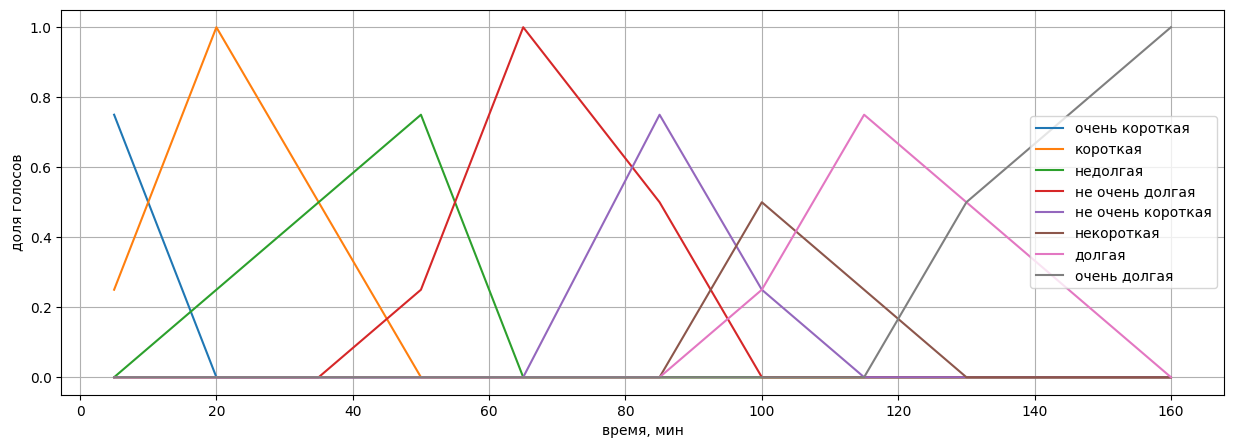

In [55]:
%matplotlib inline
# построение графиков для лингвистическй переменной
from matplotlib import pyplot as plt

times = np.array([5, 20, 35, 50, 65, 85, 100, 115, 130, 145, 160])

very_short = np.array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) / 4
short      = np.array([1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0]) / 4
not_long   = np.array([0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0]) / 4
not_vlong  = np.array([0, 0, 0, 1, 4, 2, 0, 0, 0, 0, 0]) / 4
not_vshort = np.array([0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0]) / 4
not_short  = np.array([0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0]) / 4
long       = np.array([0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0]) / 4
very_long  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4]) / 4

plt.figure(figsize=(15, 5))
plt.plot(times, very_short, label='очень короткая')
plt.plot(times, short, label='короткая')
plt.plot(times, not_long, label='недолгая')
plt.plot(times, not_vlong, label='не очень долгая')
plt.plot(times, not_vshort, label='не очень короткая')
plt.plot(times, not_short, label='некороткая')
plt.plot(times, long, label='долгая')
plt.plot(times, very_long, label='очень долгая')
plt.xlabel('время, мин')
plt.ylabel('доля голосов')
plt.legend()
plt.grid()
plt.show()